数据预处理

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

medal_counts = pd.read_csv('summerOly_medal_counts.csv')


def medal_count_per_country():
    medal_counts['Year'] = medal_counts['Year'].astype(int)
    country_year_medals = medal_counts.groupby(
        ['NOC', 'Year'])['Total'].sum().reset_index()
    countries = country_year_medals['NOC'].unique()
    selected_countries = countries[:1]
    plt.figure(figsize=(14, 8))
    for country in selected_countries:
        country_data = country_year_medals[country_year_medals['NOC'] == country]
        plt.plot(country_data['Year'], country_data['Total'], label=country)
    plt.title('Total Medals Over Years for Selected Countries', fontsize=14)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Total Medals', fontsize=12)
    plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

第一问建模

In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

medal_counts = pd.read_csv('summerOly_medal_counts.csv')
hosts = pd.read_csv('summerOly_hosts.csv')
programs = pd.read_csv('summerOly_programs.csv')
athletes = pd.read_csv('summerOly_athletes.csv')

# Model1
# 数据集搭建
# 目前暂且假设特征包括 前三届的平均奖牌数、参加的项目数，参加的运动员数目和是否为东道主
olympic_country_codes = {
    # 现存国家/地区
    "Afghanistan": "AFG",
    "Albania": "ALB",
    "Algeria": "ALG",
    "American Samoa": "ASA",
    "Andorra": "AND",
    "Angola": "ANG",
    "Antigua and Barbuda": "ANT",
    "Argentina": "ARG",
    "Armenia": "ARM",
    "Aruba": "ARU",
    "Australia": "AUS",
    "Austria": "AUT",
    "Azerbaijan": "AZE",
    "Bahamas": "BAH",
    "Bahrain": "BRN",
    "Bangladesh": "BAN",
    "Barbados": "BAR",
    "Belarus": "BLR",
    "Belgium": "BEL",
    "Belize": "BIZ",
    "Benin": "BEN",
    "Bermuda": "BER",
    "Bhutan": "BHU",
    "Bolivia": "BOL",
    "Bosnia and Herzegovina": "BIH",
    "Botswana": "BOT",
    "Brazil": "BRA",
    "British Virgin Islands": "IVB",
    "Brunei": "BRU",
    "Bulgaria": "BUL",
    "Burkina Faso": "BUR",
    "Burundi": "BDI",
    "Cabo Verde": "CPV",
    "Cambodia": "CAM",
    "Cameroon": "CMR",
    "Canada": "CAN",
    "Cayman Islands": "CAY",
    "Central African Republic": "CAF",
    "Chad": "CHA",
    "Chile": "CHI",
    "China": "CHN",
    "Colombia": "COL",
    "Comoros": "COM",
    "Congo": "CGO",
    "Congo (DRC)": "COD",
    "Cook Islands": "COK",
    "Costa Rica": "CRC",
    "Croatia": "CRO",
    "Cuba": "CUB",
    "Cyprus": "CYP",
    "Czech Republic": "CZE",
    "Denmark": "DEN",
    "Djibouti": "DJI",
    "Dominica": "DMA",
    "Dominican Republic": "DOM",
    "Ecuador": "ECU",
    "Egypt": "EGY",
    "El Salvador": "ESA",
    "Equatorial Guinea": "GEQ",
    "Eritrea": "ERI",
    "Estonia": "EST",
    "Eswatini": "SWZ",
    "Ethiopia": "ETH",
    "Fiji": "FIJ",
    "Finland": "FIN",
    "France": "FRA",
    "Gabon": "GAB",
    "Gambia": "GAM",
    "Georgia": "GEO",
    "Germany": "GER",
    "Ghana": "GHA",
    "Great Britain": "GBR",
    "Greece": "GRE",
    "Grenada": "GRN",
    "Guam": "GUM",
    "Guatemala": "GUA",
    "Guinea": "GUI",
    "Guinea-Bissau": "GBS",
    "Guyana": "GUY",
    "Haiti": "HAI",
    "Honduras": "HON",
    "Hong Kong": "HKG",
    "Hungary": "HUN",
    "Iceland": "ISL",
    "India": "IND",
    "Indonesia": "INA",
    "Iran": "IRI",
    "Iraq": "IRQ",
    "Ireland": "IRL",
    "Israel": "ISR",
    "Italy": "ITA",
    "Ivory Coast": "CIV",
    "Jamaica": "JAM",
    "Japan": "JPN",
    "Jordan": "JOR",
    "Kazakhstan": "KAZ",
    "Kenya": "KEN",
    "Kiribati": "KIR",
    "Kosovo": "KOS",
    "Kuwait": "KUW",
    "Kyrgyzstan": "KGZ",
    "Laos": "LAO",
    "Latvia": "LAT",
    "Lebanon": "LBN",
    "Lesotho": "LES",
    "Liberia": "LBR",
    "Libya": "LBA",
    "Liechtenstein": "LIE",
    "Lithuania": "LTU",
    "Luxembourg": "LUX",
    "Madagascar": "MAD",
    "Malawi": "MAW",
    "Malaysia": "MAS",
    "Maldives": "MDV",
    "Mali": "MLI",
    "Malta": "MLT",
    "Marshall Islands": "MHL",
    "Mauritania": "MTN",
    "Mauritius": "MRI",
    "Mexico": "MEX",
    "Micronesia": "FSM",
    "Moldova": "MDA",
    "Monaco": "MON",
    "Mongolia": "MGL",
    "Montenegro": "MNE",
    "Morocco": "MAR",
    "Mozambique": "MOZ",
    "Myanmar": "MYA",
    "Namibia": "NAM",
    "Nauru": "NRU",
    "Nepal": "NEP",
    "Netherlands": "NED",
    "New Zealand": "NZL",
    "Nicaragua": "NCA",
    "Niger": "NIG",
    "Nigeria": "NGR",
    "North Macedonia": "MKD",
    "Norway": "NOR",
    "Oman": "OMA",
    "Pakistan": "PAK",
    "Palau": "PLW",
    "Palestine": "PLE",
    "Panama": "PAN",
    "Papua New Guinea": "PNG",
    "Paraguay": "PAR",
    "Peru": "PER",
    "Philippines": "PHI",
    "Poland": "POL",
    "Portugal": "POR",
    "Puerto Rico": "PUR",
    "Qatar": "QAT",
    "Romania": "ROU",
    # "Russia": "RUS",
    "Rwanda": "RWA",
    "Saint Kitts and Nevis": "SKN",
    "Saint Lucia": "LCA",
    "Saint Vincent and the Grenadines": "VIN",
    "Samoa": "SAM",
    "San Marino": "SMR",
    "Sao Tome and Principe": "STP",
    "Saudi Arabia": "KSA",
    "Senegal": "SEN",
    "Serbia": "SRB",
    "Seychelles": "SEY",
    "Sierra Leone": "SLE",
    "Singapore": "SGP",
    "Slovakia": "SVK",
    "Slovenia": "SLO",
    "Solomon Islands": "SOL",
    "Somalia": "SOM",
    "South Africa": "RSA",
    "South Korea": "KOR",
    "South Sudan": "SSD",
    "Spain": "ESP",
    "Sri Lanka": "SRI",
    "Sudan": "SUD",
    "Suriname": "SUR",
    "Sweden": "SWE",
    "Switzerland": "SUI",
    "Syria": "SYR",
    "Tajikistan": "TJK",
    "Tanzania": "TAN",
    "Thailand": "THA",
    "Timor-Leste": "TLS",
    "Togo": "TOG",
    "Tonga": "TGA",
    "Trinidad and Tobago": "TTO",
    "Tunisia": "TUN",
    "Turkey": "TUR",
    "Turkmenistan": "TKM",
    "Tuvalu": "TUV",
    "Uganda": "UGA",
    "Ukraine": "UKR",
    "United Arab Emirates": "UAE",
    "United States": "USA",
    "Uruguay": "URU",
    "Uzbekistan": "UZB",
    "Vanuatu": "VAN",
    "Vatican": "VAT",
    "Venezuela": "VEN",
    "Vietnam": "VIE",
    "Virgin Islands": "ISV",
    "Yemen": "YEM",
    "Zambia": "ZAM",
    "Zimbabwe": "ZIM",

    # 历史国家/地区
    "Czechoslovakia": "TCH",
    # "East Germany": "GDR",
    # "West Germany": "FRG",
    "East Germany": "GER",
    "West Germany": "GER",
    # "Soviet Union": "URS",
    "Yugoslavia": "YUG",
    "Serbia and Montenegro": "SCG",
    "North Yemen": "YAR",
    "South Yemen": "YMD",

    # 手动添加
    # "Bohemia": "TCH",
    # "Australasia": "AUS",
    "North Korea": "PRK",
    "Formosa": "TPE",
    "Taiwan": "TPE",
    "Chinese Taipei": "TPE",
    # "Refugee Olympic Team": "ROT",
    # "ROC": "RUS",
    # "Macedonia": "MKD",
    # "Ceylon": "SRI",
    # "United Team of Germany": "GER"
}
# 将 NOC 转化成三位国家代码，并去除字典中没有的国家代码
medal_counts = medal_counts[medal_counts['NOC'].map(
    olympic_country_codes).notna()]
medal_counts['NOC'] = medal_counts['NOC'].map(olympic_country_codes)
# medal_counts.to_csv('medal_counts_updated.csv',index=False)
# print(medal_counts[:15].to_string())
# 是否为东道主
model1_dataset = pd.merge(medal_counts, hosts, on='Year', how='left')
# print(model1_dataset.head())
model1_dataset['is_host'] = (
    model1_dataset['NOC_x'] == model1_dataset['NOC_y']).astype(int)
model1_dataset = model1_dataset.drop(columns=['Host', 'NOC_y'])
model1_dataset = model1_dataset.rename(columns={'NOC_x': 'NOC'})
# print(model1_dataset.to_string(index=False))
# 此届的项目数


def calculate_new_column(row):
    year = str(row['Year'])
    return int(programs.loc[71, year])


model1_dataset['programs'] = model1_dataset.apply(calculate_new_column, axis=1)
# print(model1_dataset.to_string(index=False))
# 运动员数目
athletes_num = athletes.groupby(
    ['NOC', 'Year']).size().reset_index(name='athletes_num')
model1_dataset = pd.merge(model1_dataset, athletes_num, on=[
                          'NOC', 'Year'], how='left')
model1_dataset = model1_dataset.dropna(subset=['athletes_num'])
# print(model1_dataset.to_string())
# 前三届奖牌数
grouped = model1_dataset.groupby('NOC')
# 初始化两个列表来存储平均金牌数和平均奖牌总数
average_gold = []
average_total_medals = []
# 遍历每个国家的分组
for country, group in grouped:
    group = group.sort_values(by='Year')
    avg_gold_list = []
    avg_total_medals_list = []
    # 遍历每个国家的每届奥运会
    for index, row in group.iterrows():
        current_year = row['Year']
        previous_years = group[(group['Year'] < current_year) & (
            group['Year'] >= current_year - 12)]
        if len(previous_years) > 0:
            avg_gold = previous_years['Gold'].mean()
            avg_total_medals = previous_years['Total'].mean()
        else:
            avg_gold = 0
            avg_total_medals = 0
        avg_gold_list.append(avg_gold)
        avg_total_medals_list.append(avg_total_medals)
    # 将结果添加到原始数据中
    model1_dataset.loc[group.index, 'Average_Gold'] = avg_gold_list
    model1_dataset.loc[group.index,
                       'Average_Total_Medals'] = avg_total_medals_list
print(model1_dataset.to_string())


# # 建立模型
# features = ['is_host', 'programs', 'athletes_num',
#             'Average_Gold', 'Average_Total_Medals']
# target = 'Gold'
# X = model1_dataset[features]
# y = model1_dataset[target]
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=42)

# # 线性回归
# lr_model = LinearRegression()
# lr_model.fit(X_train, y_train)
# lr_pred = lr_model.predict(X_test)
# print(lr_model.predict([[1, 320, 1000, 41.67, 120]]))
# # 随机森林回归模型
# rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
# rf_model.fit(X_train, y_train)
# rf_pred = rf_model.predict(X_test)
# print(rf_model.predict([[1, 320, 1000, 41.67, 120]]))
# # LightGBM
# lgb_model = LGBMRegressor(n_estimators=250, random_state=42)
# lgb_model.fit(X_train, y_train)
# lgb_pred = lgb_model.predict(X_test)

# # 评估模型
# print("Linear Regression MSE:", mean_squared_error(y_test, lr_pred))
# print("Random Forest MSE:", mean_squared_error(y_test, rf_pred))
# print("LGBM MSE:", mean_squared_error(y_test, lgb_pred))

In [20]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error,r2_score,root_mean_squared_error

file_path = 'test.csv'

df = pd.read_csv(file_path)
hosts = pd.read_csv('summerOly_hosts.csv')

columns = ['NOC', 'Year', 'Athletics', 'Balls', 'Combat', 'Shooting', 'Swimming',
           'Cycling', 'Weightlifting', 'WaterSport', 'Others', 'Gymnastics', 'Diving']
data = []
for (noc, year), group in df.groupby(['NOC', 'Year']):
    medals = {'NOC': noc, 'Year': year}
    for sport in columns[2:]:
        medals[sport] = group[group['Sport'] == sport]['Medal'].sum()
    data.append(medals)
result_df = pd.DataFrame(data)
medal_counts = pd.read_csv('medal_counts_updated.csv')
result = pd.merge(result_df, medal_counts, on=['NOC', 'Year'], how='left')
result = result.drop(columns=['Rank', 'Silver', 'Bronze']).fillna(0)

result = pd.merge(result, hosts, on='Year', how='left')
result['is_host'] = (
    result['NOC_x'] == result['NOC_y']).astype(int)
result = result.drop(columns=['Host', 'NOC_y'])
result = result.rename(columns={'NOC_x': 'NOC'})

# 前三届奖牌数
grouped = medal_counts.groupby('NOC')
# 初始化两个列表来存储平均金牌数和平均奖牌总数
average_gold = []
average_total_medals = []
# 遍历每个国家的分组
for country, group in grouped:
    group = group.sort_values(by='Year')
    avg_gold_list = []
    avg_total_medals_list = []
    # 遍历每个国家的每届奥运会
    for index, row in group.iterrows():
        current_year = row['Year']
        previous_years = group[(group['Year'] < current_year) & (
            group['Year'] >= current_year - 12)]
        if len(previous_years) > 0:
            avg_gold = previous_years['Gold'].mean()
            avg_total_medals = previous_years['Total'].mean()
        else:
            avg_gold = 0
            avg_total_medals = 0
        avg_gold_list.append(avg_gold)
        avg_total_medals_list.append(avg_total_medals)
    # 将结果添加到原始数据中
    medal_counts.loc[group.index, 'Average_Gold'] = avg_gold_list
    medal_counts.loc[group.index,
                       'Average_Total_Medals'] = avg_total_medals_list
result=pd.merge(result,medal_counts,on=['NOC','Year'],how='left')
result=result.drop(columns=['Rank', 'Gold_y', 'Silver', 'Bronze', 'Total_y'])
result = result.rename(columns={'Gold_x': 'Gold','Total_x':'Total'})
result=result.fillna(0)
# result.to_csv('model1_data.csv',index=False)
print(result.to_string())


features = ['Athletics', 'Balls', 'Combat', 'Shooting', 'Swimming', 'Cycling',
            'Weightlifting', 'WaterSport', 'Others', 'Gymnastics', 'Diving', 'is_host', 'Average_Gold', 'Average_Total_Medals']
target_gold = 'Gold'
target_total='Total'
X = result[features]
y_gold = result[target_gold]
y_total=result[target_total]
X_train_gold, X_test_gold, y_train_gold, y_test_gold = train_test_split(
    X, y_gold, test_size=0.2, random_state=42)
X_train_total, X_test_total, y_train_total, y_test_total = train_test_split(
    X, y_total, test_size=0.2, random_state=42)
# 线性回归
lr_model_gold = LinearRegression()
lr_model_gold.fit(X_train_gold, y_train_gold)
lr_pred_gold = lr_model_gold.predict(X_test_gold)

lr_model_total = LinearRegression()
lr_model_total.fit(X_train_total, y_train_total)
lr_pred_total = lr_model_total.predict(X_test_total)

# print(lr_model.predict([[1, 320, 1000, 41.67, 120]]))
# 随机森林回归模型
rf_model_gold = RandomForestRegressor(n_estimators=1000,random_state=42)
rf_model_gold.fit(X_train_gold, y_train_gold)
rf_pred_gold = rf_model_gold.predict(X_test_gold)

rf_model_total = RandomForestRegressor(n_estimators=1000, random_state=42)
rf_model_total.fit(X_train_total, y_train_total)
rf_pred_total = rf_model_total.predict(X_test_total)
# print(rf_model.predict([[1, 320, 1000, 41.67, 120]]))
# LightGBM
lgb_model_gold = LGBMRegressor(n_estimators=1000, random_state=42)
lgb_model_gold.fit(X_train_gold, y_train_gold)
lgb_pred_gold = lgb_model_gold.predict(X_test_gold)

lgb_model_total = LGBMRegressor(n_estimators=1000, random_state=42)
lgb_model_total.fit(X_train_total, y_train_total)
lgb_pred_total = lgb_model_total.predict(X_test_total)
# XGBoost
xgb_model_gold = XGBRegressor(
    n_estimators=1000,  # 树的数量
    learning_rate=0.1,  # 学习率
    max_depth=3,       # 树的最大深度
    subsample=0.8,     # 子采样比例
    colsample_bytree=0.8,  # 每棵树使用的特征采样比例
    random_state=42
)
xgb_model_gold.fit(X_train_gold, y_train_gold)
xgb_pred_gold = xgb_model_gold.predict(X_test_gold)
xgb_model_total = XGBRegressor(
    n_estimators=1000,  # 树的数量
    learning_rate=0.1,  # 学习率
    max_depth=3,       # 树的最大深度
    subsample=0.8,     # 子采样比例
    colsample_bytree=0.8,  # 每棵树使用的特征采样比例
    random_state=42
)
xgb_model_total.fit(X_train_total, y_train_total)
xgb_pred_total = xgb_model_total.predict(X_test_total)

# 评估模型
print("Linear Regression Gold MSE:", mean_squared_error(y_test_gold, lr_pred_gold))
print("Linear Regression Total MSE:", mean_squared_error(y_test_total, lr_pred_total))
print("Linear Regression Gold RMSE:",root_mean_squared_error(y_test_gold, lr_pred_gold))
print("Linear Regression Total RMSE:",root_mean_squared_error(y_test_total, lr_pred_total))
print("Linear Regression Gold r2_score:", r2_score(y_test_gold, lr_pred_gold))
print("Linear Regression Total r2_score:",r2_score(y_test_total, lr_pred_total))

print("Random Forest Gold MSE:", mean_squared_error(y_test_gold, rf_pred_gold))
print("Random Forest Total MSE:", mean_squared_error(y_test_total, rf_pred_total))
print("Random Forest Gold RMSE:", root_mean_squared_error(y_test_gold, rf_pred_gold))
print("Random Forest Total RMSE:", root_mean_squared_error(y_test_total, rf_pred_total))
print("Random Forest Gold r2_score:", r2_score(y_test_gold, rf_pred_gold))
print("Random Forest Total r2_score:", r2_score(y_test_total, rf_pred_total))

print("LGBM Gold MSE:", mean_squared_error(y_test_gold, lgb_pred_gold))
print("LGBM Total MSE:", mean_squared_error(y_test_total, lgb_pred_total))
print("LGBM Gold RMSE:", root_mean_squared_error(y_test_gold, lgb_pred_gold))
print("LGBM Total RMSE:", root_mean_squared_error(y_test_total, lgb_pred_total))
print("LGBM Gold r2_score:", r2_score(y_test_gold, lgb_pred_gold))
print("LGBM Total r2_score:", r2_score(y_test_total, lgb_pred_total))

print("xgBoost Gold MSE:", mean_squared_error(y_test_gold, xgb_pred_gold))
print("xgBoost Total MSE:", mean_squared_error(y_test_total, xgb_pred_total))
print("xgBoost Gold RMSE:", root_mean_squared_error(y_test_gold, xgb_pred_gold))
print("xgBoost Total RMSE:", root_mean_squared_error(y_test_total, xgb_pred_total))
print("xgBoost Gold r2_score:", r2_score(y_test_gold, xgb_pred_gold))
print("xgBoost Total r2_score:", r2_score(y_test_total, xgb_pred_total))

作图

In [88]:
# 2028年预测结果图
import pandas as pd
from scipy.special import expit

df = pd.read_csv('test.csv')
hosts = pd.read_csv('summerOly_hosts.csv')

columns = ['NOC', 'Year', 'Athletics', 'Balls', 'Combat', 'Shooting', 'Swimming',
           'Cycling', 'Weightlifting', 'WaterSport', 'Others', 'Gymnastics', 'Diving']
data_2020 = []
data_2024 = []
df_2020 = df[df['Year'] == 2020]
df_2024 = df[df['Year'] == 2024]
for (noc, year), group in df_2020.groupby(['NOC', 'Year']):
    medals = {'NOC': noc, 'Year': year}
    for sport in columns[2:]:
        medals[sport] = group[group['Sport'] == sport]['Medal'].sum()
    data_2020.append(medals)
result_2020 = pd.DataFrame(data_2020)
# print(result_2020.to_string())

for (noc, year), group in df_2024.groupby(['NOC', 'Year']):
    medals = {'NOC': noc, 'Year': year}
    for sport in columns[2:]:
        medals[sport] = group[group['Sport'] == sport]['Medal'].sum()
    data_2024.append(medals)
result_2024 = pd.DataFrame(data_2024)
# print(result_2024.to_string())
# print(result_2020['NOC']==result_2024['NOC'])

merged = pd.merge(result_2020, result_2024, on='NOC',
                  suffixes=('_2020', '_2024'))
for project in ['Athletics', 'Balls', 'Combat', 'Shooting', 'Swimming',
                'Cycling', 'Weightlifting', 'WaterSport', 'Others', 'Gymnastics', 'Diving']:
    merged[project + '_change'] = merged[project +
                                         '_2024'] - merged[project + '_2020']
change_columns = ['NOC'] + [project + '_change' for project in ['Athletics', 'Balls', 'Combat',
                                                                'Shooting', 'Swimming', 'Cycling', 'Weightlifting', 'WaterSport', 'Others', 'Gymnastics', 'Diving']]
change = merged[change_columns]
# print(change.to_string())

data_2028 = pd.merge(result_2024, change, on='NOC')
for project in ['Athletics', 'Balls', 'Combat', 'Shooting', 'Swimming',
                'Cycling', 'Weightlifting', 'WaterSport', 'Others', 'Gymnastics', 'Diving']:
    def norm(x):
        if abs(x) <= 10:
            return x
        elif abs(x) > 10 and abs(x) <= 20:
            return int(0.75*x+2.5)
        else:
            return int(0.5*x+7.5)
    data_2028[project] += data_2028[project+'_change'].apply(norm)
for project in ['Athletics', 'Balls', 'Combat', 'Shooting', 'Swimming',
                'Cycling', 'Weightlifting', 'WaterSport', 'Others', 'Gymnastics', 'Diving']:
    data_2028.loc[data_2028['NOC'] == 'FRA', project] -= data_2028.loc[data_2028['NOC']
                                                                       == 'FRA', project+'_change'].apply(norm)
    for idx in data_2028[data_2028['NOC'] == 'USA'].index:
        data_2028.loc[idx, project] = int(1.1 * data_2028.loc[idx, project])
data_2028 = data_2028.drop(columns=['Year']+[project + '_change' for project in ['Athletics', 'Balls', 'Combat',
                                                                                 'Shooting', 'Swimming', 'Cycling', 'Weightlifting', 'WaterSport', 'Others', 'Gymnastics', 'Diving']])
numeric_columns = data_2028.select_dtypes(include=['number']).columns
for column in numeric_columns:
    data_2028[column] = data_2028[column].map(
        lambda x: max(x, 0) if pd.api.types.is_number(x) else x)
data_2028['is_host'] = 0
data_2028.loc[data_2028['NOC'] == 'USA', 'is_host'] = 1
medal_counts = pd.read_csv('medal_counts_updated.csv')

df = pd.read_csv('medal_counts_updated.csv')
df_filtered = df[df['Year'].isin([2024, 2020, 2016])]
avg_gold = df_filtered.groupby('NOC')['Gold'].mean().reset_index()
avg_medals = df_filtered.groupby('NOC')['Total'].mean().reset_index()
data_2028 = pd.merge(data_2028, avg_gold, on='NOC', how='left').fillna(0)
data_2028 = pd.merge(data_2028, avg_medals, on='NOC', how='left').fillna(0)
data_2028 = data_2028.rename(columns={'Gold': 'Average_Gold',
                                      'Total': 'Average_Total_Medals'})
# data_2028.to_csv('Oly_2028.csv',index=False)
# print(data_2028.to_string())
features = ['Athletics', 'Balls', 'Combat', 'Shooting', 'Swimming', 'Cycling',
            'Weightlifting', 'WaterSport', 'Others', 'Gymnastics', 'Diving', 'is_host', 'Average_Gold', 'Average_Total_Medals']
X = data_2028[features]
pred_gold = rf_model_gold.predict(X)
pred_total = rf_model_total.predict(X)

data_2028['pred_gold'] = pred_gold.astype(int)
data_2028['pred_total'] = pred_total.astype(int)

# print(data_2028.to_string())

     NOC  Athletics  Balls  Combat  Shooting  Swimming  Cycling  Weightlifting  WaterSport  Others  Gymnastics  Diving  is_host  Average_Gold  Average_Total_Medals  pred_gold  pred_total  medal_prob
3    AND          1      0       0         0         0        0              0           4       0           0       0        0           0.0                   0.0          0           0         0.5
4    ANG          1     16       1         0         2        0              0          12       0           0       0        0           0.0                   0.0          0           0         0.5
5    ANT          2      0       0         0         2        0              0           1       0           0       0        0           0.0                   0.0          0           0         0.5
8    ARU          0      0       0         1         3        2              0           4       0           0       0        0           0.0                   0.0          0           0         0.5
9    

In [37]:
import numpy as np
from tqdm import tqdm
from sklearn.utils import resample

n_iterations = 500
predictions_gold = []
predictions_total = []

for i in tqdm(range(n_iterations)):
    # Bootstrap 采样
    X_resampled_gold, y_resampled_gold = resample(X_train_gold, y_train_gold)
    X_resampled_total, y_resampled_total = resample(X_train_total, y_train_total)

    # 重新训练模型并预测
    rf_model_gold.fit(X_resampled_gold, y_resampled_gold)
    predictions_gold.append(rf_model_gold.predict(X))
    rf_model_total.fit(X_resampled_total, y_resampled_total)
    predictions_total.append(rf_model_total.predict(X))
    # rows = len(predictions_total)  # 行数
    # cols = len(predictions_total[0])
    # print(rows,cols)

# 计算预测区间
predictions_gold = np.array(predictions_gold)
lower_bound_gold = np.percentile(predictions_gold, 2.5, axis=0)
upper_bound_gold = np.percentile(predictions_gold, 97.5, axis=0)

predictions_total = np.array(predictions_total)
lower_bound_total = np.percentile(predictions_total, 2.5, axis=0)
upper_bound_total = np.percentile(predictions_total, 97.5, axis=0)

data_2028['lower_bound_gold'] = np.nan_to_num(lower_bound_gold).astype(int)
data_2028['upper_bound_gold'] = np.nan_to_num(upper_bound_gold).astype(int)
data_2028['lower_bound_total'] = np.nan_to_num(lower_bound_total).astype(int)
data_2028['upper_bound_total'] = np.nan_to_num(upper_bound_total).astype(int)
# print(data_2028.to_string())
data_2028.to_csv('Oly_2028_pred.csv')

100%|██████████| 500/500 [33:24<00:00,  4.01s/it]


In [171]:
latex = pd.read_csv('Oly_2028_pred.csv')
column = ['NOC', 'pred_gold', 'pred_total', 'lower_bound_gold',
          'upper_bound_gold', 'lower_bound_total', 'upper_bound_total']
latex = latex[column]
latex = latex.sort_values(by=['pred_total', 'pred_gold'], ascending=False)
latex['Rank'] = range(1, len(latex) + 1)
latex = latex.head(50)
latex = latex[['Rank'] + [col for col in latex.columns if col != 'Rank']]
latex['Gold_95%_CI'] = latex.apply(
    lambda row: f"[{row['lower_bound_gold']}, {row['upper_bound_gold']}]", axis=1)
latex['Total_95%_CI'] = latex.apply(
    lambda row: f"[{row['lower_bound_total']}, {row['upper_bound_total']}]", axis=1)
latex = latex.drop(columns=['lower_bound_gold', 'upper_bound_gold',
             'lower_bound_total', 'upper_bound_total'])
latex = latex.rename(columns={'pred_gold': 'Gold', 'pred_total': 'Total'})
country_names = {
    'ROC': 'Russia',
    'RUS': 'Russia',
    'USA': 'United States',
    'CHN': 'China',
    'GBR': 'United Kingdom',
    'ITA': 'Italy',
    'FRA': 'France',
    'AUS': 'Australia',
    'JPN': 'Japan',
    'GER': 'Germany',
    'CAN': 'Canada',
    'NED': 'Netherlands',
    'KOR': 'South Korea',
    'ESP': 'Spain',
    'HUN': 'Hungary',
    'BRA': 'Brazil',
    'NZL': 'New Zealand',
    'UKR': 'Ukraine',
    'UZB': 'Uzbekistan',
    'BEL': 'Belgium',
    'SRB': 'Serbia',
    'POL': 'Poland',
    'DEN': 'Denmark',
    'SUI': 'Switzerland',
    'KAZ': 'Kazakhstan',
    'TUR': 'Turkey',
    'EGY': 'Egypt',
    'KEN': 'Kenya',
    'NGR': 'Nigeria',
    'ROU': 'Romania',
    'JAM': 'Jamaica',
    'SWE': 'Sweden',
    'CRO': 'Croatia',
    'GRE': 'Greece',
    'IRL': 'Ireland',
    'NOR': 'Norway',
    'BUL': 'Bulgaria',
    'CZE': 'Czech Republic',
    'RSA': 'South Africa',
    'AZE': 'Azerbaijan',
    'CUB': 'Cuba',
    'GEO': 'Georgia',
    'TPE': 'Chinese Taipei (Taiwan)',
    'COL': 'Colombia',
    'MEX': 'Mexico',
    'PHI': 'Philippines',
    'IND': 'India',
    'SLO': 'Slovenia',
    'THA': 'Thailand',
    'AUT': 'Austria',
    'IRI': 'Iran',
    'ISR': 'Israel'
}
latex['NOC']=latex['NOC'].map(country_names)
column_order=['Rank','NOC','Gold','Gold_95%_CI','Total','Total_95%_CI']
latex=latex[column_order]
latex_table = latex.to_latex(index=False)  # index=False 不显示索引
# print(latex_table)

[LightGBM] [Info] Number of positive: 127, number of negative: 921
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000471 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 175
[LightGBM] [Info] Number of data points in the train set: 1048, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.121183 -> initscore=-1.981273
[LightGBM] [Info] Start training from score -1.981273
Logistic Regression Log_Loss: 2.7409622349138516
Linear Regression Log_Loss: 0.40442008684239894
Random Forest Log_Loss: 0.39552101313666477
LightGBM Log_Loss: 0.3419585046626155
XGBoost Log_Loss: 0.6507728548762566
                        NOC  medal_prob
148               Palestine    0.459854
77                   Guinea    0.341743
58              El Salvador    0.237529
158                   Samoa    0.173588
34                    Congo    0

C:\Users\86118\AppData\Local\Temp\ipykernel_9584\1256094765.py:152: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['NOC'] = filtered_data['NOC'].map(country_dict)


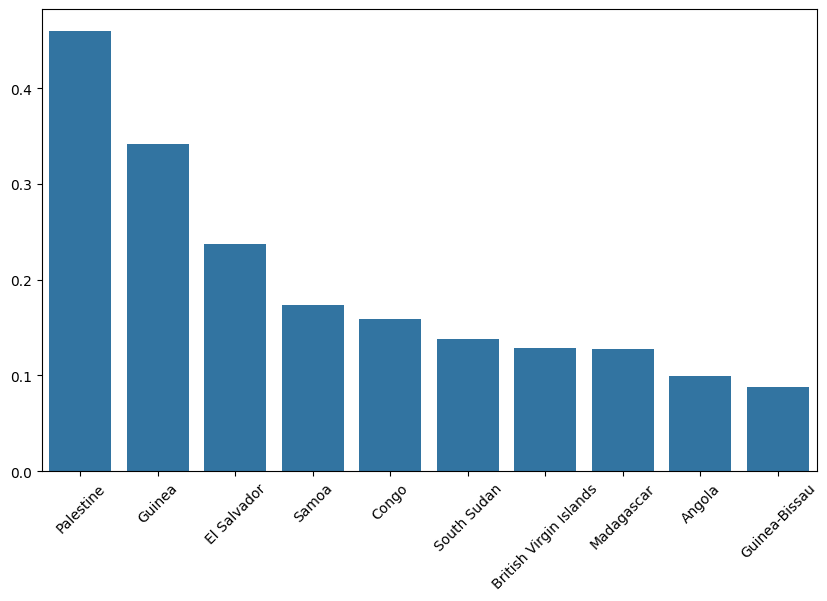

In [137]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error, log_loss
import seaborn as sns
import matplotlib.pyplot as plt

# 重新处理一下first_medals.csv
athletes = pd.read_csv('summerOly_athletes.csv')
athletes['Medal'] = athletes['Medal'].map(
    {'No medal': 0}).fillna(1).astype(int)
athletes = athletes[['NOC', 'Year', 'Medal']]
# print(athletes)
athletes = athletes[athletes['Medal'] == 1]
athletes =athletes.drop(columns='Medal')
first_medal = athletes.groupby('NOC', as_index=False)['Year'].min()
first_medal = first_medal.rename(columns={'Year': 'FirstMedalYear'})
first_medal['FirstMedalYear']=first_medal['FirstMedalYear'].astype(int)
# print(first_medal.to_string(index=False))

model1_data = pd.read_csv('model1_data.csv')

data = pd.merge(model1_data, first_medal, on='NOC', how='left')
data['GetMedal'] = data.apply(lambda row: 0 if (
    row['Year'] < row['FirstMedalYear'] or pd.isna(row['FirstMedalYear'])) else 1, axis=1)
data = data[(data['GetMedal'] == 0) | ((data['GetMedal'] == 1) & (data['Year']==data['FirstMedalYear']))]
# print(data.to_string())

features = ['Athletics', 'Balls', 'Combat', 'Shooting', 'Swimming', 'Cycling', 'Weightlifting',
            'WaterSport', 'Others', 'Gymnastics', 'Diving', 'is_host', 'Average_Gold',  'Average_Total_Medals']
target = 'GetMedal'

X = data[features]
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

logic_model = LogisticRegression()
logic_model.fit(X_train, y_train)
logic_pred = logic_model.predict(X_test)

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
# lgb_model = LGBMRegressor(n_estimators=60,random_state=42)
# lgb_model.fit(X_train, y_train)
# lgb_pred = lgb_model.predict(X_test)
params = {
    'objective': 'binary',  # 二分类任务
    'metric': 'binary_logloss',  # 二分类损失函数
    'boosting_type': 'gbdt',
    # 'reg_lambda': 1,
}
train_data = lgb.Dataset(X_train, label=y_train)
lgb_model = lgb.train(params, train_data, num_boost_round=100)
lgb_pred = lgb_model.predict(X_test)

xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

print("Logistic Regression Log_Loss:", log_loss(y_test, logic_pred))
print("Linear Regression Log_Loss:", log_loss(y_test, lr_pred))
print("Random Forest Log_Loss:", log_loss(y_test, rf_pred))
print("LightGBM Log_Loss:", log_loss(y_test, lgb_pred))
print("XGBoost Log_Loss:", log_loss(y_test, xgb_pred))
data_2028 = pd.read_csv('Oly_2028.csv')
input = data_2028[features]
output=lgb_model.predict(input)
data_2028['medal_prob']=output
# print(data_2028.to_string(index=False))
filtered_data = data_2028[~data_2028['NOC'].isin(first_medal['NOC'])]

country_dict = {
    'AND': 'Andorra',
    'ANG': 'Angola',
    'ANT': 'Antigua and Barbuda',
    'ARU': 'Aruba',
    'ASA': 'American Samoa',
    'BAN': 'Bangladesh',
    'BEN': 'Benin',
    'BHU': 'Bhutan',
    'BIH': 'Bosnia and Herzegovina',
    'BIZ': 'Belize',
    'BOL': 'Bolivia',
    'BRU': 'Brunei',
    'CAF': 'Central African Republic',
    'CAM': 'Cambodia',
    'CAY': 'Cayman Islands',
    'CGO': 'Congo',
    'CHA': 'Chad',
    'COD': 'Democratic Republic of the Congo',
    'COK': 'Cook Islands',
    'COM': 'Comoros',
    'ESA': 'El Salvador',
    'FSM': 'Federated States of Micronesia',
    'GAM': 'Gambia',
    'GBS': 'Guinea-Bissau',
    'GEQ': 'Equatorial Guinea',
    'GUI': 'Guinea',
    'GUM': 'Guam',
    'HON': 'Honduras',
    'IVB': 'British Virgin Islands',
    'KIR': 'Kiribati',
    'LAO': 'Laos',
    'LBA': 'Libya',
    'LBN': 'Lebanon',
    'LBR': 'Liberia',
    'LES': 'Lesotho',
    'LIE': 'Liechtenstein',
    'MAD': 'Madagascar',
    'MAW': 'Malawi',
    'MDV': 'Maldives',
    'MHL': 'Marshall Islands',
    'MLI': 'Mali',
    'MLT': 'Malta',
    'MTN': 'Mauritania',
    'MYA': 'Myanmar',
    'NCA': 'Nicaragua',
    'NEP': 'Nepal',
    'NRU': 'Nauru',
    'OMA': 'Oman',
    'PLE': 'Palestine',
    'PLW': 'Palau',
    'PNG': 'Papua New Guinea',
    'RWA': 'Rwanda',
    'SAM': 'Samoa',
    'SEY': 'Seychelles',
    'SKN': 'Saint Kitts and Nevis',
    'SLE': 'Sierra Leone',
    'SOL': 'Solomon Islands',
    'SOM': 'Somalia',
    'SSD': 'South Sudan',
    'STP': 'São Tomé and Príncipe',
    'SWZ': 'Eswatini',
    'TLS': 'Timor-Leste',
    'TUV': 'Tuvalu',
    'VAN': 'Vanuatu',
    'VIN': 'Saint Vincent and the Grenadines',
    'YEM': 'Yemen'
}

filtered_data['NOC'] = filtered_data['NOC'].map(country_dict)
# print(filtered_data.head())
filtered_data = filtered_data[['NOC', 'medal_prob']]
filtered_data=filtered_data.sort_values('medal_prob', ascending=False).head(10)
print(filtered_data.to_string())
# print(filtered_data['medal_prob'].sum())
plt.figure(figsize=(10,6))
sns.barplot(x='NOC', y='medal_prob', data=filtered_data)
plt.xlabel('')
plt.ylabel('')
# plt.title('Probability of Winning a Medal')
plt.xticks(rotation=45)

plt.show()

# print(result.to_string())

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

athletes = pd.read_csv('summerOly_athletes.csv')
athletes = athletes[athletes['Medal'] != 'No medal']
data = athletes[['NOC', 'Year', 'Sport', 'Medal', 'Event']].drop_duplicates()
data = data.groupby(['NOC', 'Year', 'Sport'])[
    'Medal'].count().reset_index(name='MedalCounts')
total_medals_per_country = data.groupby(
    ['NOC', 'Year'])['MedalCounts'].sum().reset_index(name='TotalMedals')
medal_data_with_totals = pd.merge(
    data, total_medals_per_country, on=['NOC', 'Year'])
medal_data_with_totals['MedalProportion'] = medal_data_with_totals['MedalCounts'] / \
    medal_data_with_totals['TotalMedals']
result = medal_data_with_totals[medal_data_with_totals['Year'] == 2024].sort_values(
    by=['NOC', 'MedalProportion'], ascending=[True, False])
top2_sport = result.groupby('NOC').head(6).sort_values(
    by=['TotalMedals', 'MedalCounts'], ascending=[False, False])
# print(top2_sport.to_string())

country_sport = medal_data_with_totals[(
    medal_data_with_totals['NOC'] == 'CHN') & (medal_data_with_totals['Sport'] == 'Swimming')]
five_event = country_sport[['Year', 'MedalProportion']]
five_event = five_event.rename(columns={'MedalProportion': 'Swimming'})

country_sport = medal_data_with_totals[(
    medal_data_with_totals['NOC'] == 'CHN') & (medal_data_with_totals['Sport'] == 'Diving')]
five_event = pd.merge(
    five_event, country_sport[['Year', 'MedalProportion']], on='Year', how='left')
five_event = five_event.rename(columns={'MedalProportion': 'Diving'})

country_sport = medal_data_with_totals[(
    medal_data_with_totals['NOC'] == 'CHN') & (medal_data_with_totals['Sport'] == 'Shooting')]
five_event = pd.merge(
    five_event, country_sport[['Year', 'MedalProportion']], on='Year', how='left')
five_event = five_event.rename(columns={'MedalProportion': 'Shooting'})

five_event['total'] = five_event['Swimming'] + \
    five_event['Diving']+five_event['Shooting']
five_event=five_event.tail(24)

print(five_event.to_string())

# # print(five_event.to_string())

# plt.figure(figsize=(10, 6))
# plt.plot(five_event['Year'], five_event['Swimming'], label='Swimming',
#          marker='^', markersize=6, linestyle='-', markerfacecolor='none')
# plt.plot(five_event['Year'], five_event['Diving'], label='Diving',
#          marker='s', markersize=6, linestyle='-', markerfacecolor='none')
# plt.plot(five_event['Year'], five_event['Shooting'], label='Shooting',
#          marker='o', markersize=6, linestyle='-', markerfacecolor='none')
# plt.plot(five_event['Year'], five_event['total'], label='total',
#         linestyle='--')
# # plt.title('Performance in Different Sports Over Years')
# plt.xlabel('')
# plt.ylabel('')
# plt.legend()
# plt.tight_layout()
# plt.show()


# print(country_sport.to_string())
# print(medal_data_with_totals[(medal_data_with_totals['MedalProportion'] > 0.1)&(medal_data_with_totals['Year']==2024)&(medal_data_with_totals['TotalMedals']>5)].to_string())


# df_top_sports = top2_sport[['NOC', 'Sport', 'MedalProportion']]
# df_top_sports['NOC'] =df_top_sports['NOC'].map(country_names)

# # 选择前10个国家的数据
# df_top_sports = df_top_sports.head(20)
# df_pivot = df_top_sports.pivot(
#     index='NOC', columns='Sport', values='MedalProportion')

# df_pivot.plot(kind='bar', stacked=True, figsize=(15, 10))
# # plt.title('Medal Proportion Contribution by Sport for Top 10 Countries')
# plt.xlabel('')
# plt.ylabel('')
# plt.xticks(rotation=45)
# # plt.legend(title='Sport')
# plt.legend(title='Sport', loc='upper left', bbox_to_anchor=(1, 1))
# plt.tight_layout()
# plt.show()

   Year  Swimming    Diving  Shooting     total
0  1988  0.142857  0.214286  0.071429  0.428571
1  1992  0.169811  0.094340  0.075472  0.339623
2  1996  0.120000  0.100000  0.100000  0.320000
3  2004  0.031746  0.142857  0.142857  0.317460
4  2008  0.060000  0.110000  0.080000  0.250000
5  2012  0.113636  0.113636  0.079545  0.306818
6  2016  0.085714  0.142857  0.100000  0.328571
7  2020  0.068182  0.136364  0.125000  0.329545
8  2024  0.131868  0.120879  0.109890  0.362637


In [11]:
medal_count=pd.read_csv('medal_counts_updated.csv')
medal_count=medal_count[medal_count['NOC']=='CHN']
cor=pd.merge(five_event,medal_count[['Year','Total']],on='Year')
cor['Swimming'] = cor['Swimming']*cor['Total']
print(cor.to_string())
print(cor['Swimming'].corr(cor['Total'], method='spearman'))

   Year  Swimming    Diving   Shooting     total  Total
0  1988  0.142857  0.214286   2.000000  0.428571     28
1  1992  0.169811  0.094340   4.075472  0.339623     54
2  1996  0.120000  0.100000   5.000000  0.320000     50
3  2004  0.031746  0.142857   9.000000  0.317460     63
4  2008  0.060000  0.110000   8.000000  0.250000    100
5  2012  0.113636  0.113636   7.318182  0.306818     92
6  2016  0.085714  0.142857   7.000000  0.328571     70
7  2020  0.068182  0.136364  11.125000  0.329545     89
8  2024  0.131868  0.120879  10.000000  0.362637     91
0.6666666666666667
